<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Modeling

# Imports

In [1]:
# import library

import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#imports for preprocessing
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
#from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#imports for processing data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
#pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

#imports for models
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso, RidgeCV, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import classification_report, precision_recall_curve, auc

#from sklearn.metrics import r2_score, mean_squared_error, plot_confusion_matrix
import statsmodels.api as sm

import pickle
pd.set_option('display.max_rows', 50)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#import dataframe
journal_df = pd.read_csv('data/output/journal_df.csv', encoding = 'utf-8')

In [3]:
#inspect
print(journal_df.info())
journal_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18636 entries, 0 to 18635
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         18636 non-null  object
 1   issue         18636 non-null  object
 2   issue_href    18636 non-null  object
 3   url           18636 non-null  object
 4   content_type  18636 non-null  object
 5   publish_date  18636 non-null  object
 6   abstract      18636 non-null  object
 7   high_HI       18636 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 1.1+ MB
None


,title,issue,issue_href,url,content_type,publish_date,abstract,high_HI
0,optical multisensor systems in analytical spec...,"March 2022, issue 3",/journal/10809/volumes-and-issues/77-3,https://link.springer.com/article/10.1134/S106...,review,2022-03-31,a review of works in developing optical multis...,0
1,liquid–liquid extraction of organic compounds ...,"August 2021, issue 8",/journal/10809/volumes-and-issues/76-8,https://link.springer.com/article/10.1134/S106...,review,2021-07-29,single-drop microextraction (sdme) and hollow-...,0


In [4]:
#drop features, rearrange
df = journal_df.drop(columns = ['issue', 'issue_href', 'url', 'publish_date'])
df = df[['high_HI', 'content_type', 'title', 'abstract']]
df

,high_HI,content_type,title,abstract
0,0,review,optical multisensor systems in analytical spec...,a review of works in developing optical multis...
1,0,review,liquid–liquid extraction of organic compounds ...,single-drop microextraction (sdme) and hollow-...
2,0,article,"determination of lanthanides in coal fly ash, ...",a method has been developed for the separation...
3,0,article,application of atmospheric pressure photoioniz...,the behavior of eight nitrogen-containing toxi...
4,0,article,simultaneous determination of sulfur mustard a...,we propose a procedure for the simultaneous de...
...,...,...,...,...
18631,1,special issue paper,monitoring of total hg in the river elbe: fia...,the development of an apparatus for the on-lin...
18632,1,special issue paper,on-line determination of mercury in river wate...,a monitor is described which provides the on-l...
18633,1,special issue paper,"determination of arsenic species in water, soi...",ion chromatographic separation coupled with ic...
18634,1,special issue paper,solar blind photocell – a simple element spec...,"an element-specific detection method, based on..."


# Preprocessing and evaluating

Due to the presence of technical words in the abstract, between stemming and lemmatizing, lemmatizing would be a more referable choice since it is able to transform words to their base while preserving the validity of the resulting words. The hope is that will be able to preserve the validity of the scientific terms, chemical names and formulas.

## Lemmatizing texts
Set function to easily apply on each row

In [238]:
#Initialize the lemmatizer
lemmatizer = nltk.WordNetLemmatizer()

#Defining a function to lemmatize the abstract
def lemma_text(text):
    words = nltk.word_tokenize(text)
    lemmed_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmed_words)

#preprocessor to remove digits and 
#to remove 2 character words (likely to be units, e.g. ml mg, ms, and other words lieklly to be english stop words e.g. he to go in by)
def preprocess_text(text):
    text = re.sub(r'\d+|\b\w{2}\b', '', text.lower()) 
    return text

In [6]:
#lemmatize the astract column, remove 2 charactern words
df['abstract'] = df['abstract'].apply(lemma_text).apply(preprocess_text)

In [7]:
#lemmatize the astract column
df['abstract'] = df['abstract'].apply(preprocess_text)

## Train-Test split of data

In [8]:
#assign X & y and straitfy the imbalance observed during cleaning
X = df['abstract']
y = df['high_HI']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33, #0.33 to reduce data imbalance impact
                                                    stratify=y,     #account for data imabalance.
                                                    random_state=42)


## Scoring evaluation
 - F1-scores is used to balance the scoring of both side since it is the harmonic mean between precision and recall and in this case is a way to deal with the trade-off from trying to balance higher recall and higher precision without sacrificing ther other too much
     - Accuracy not used because of the data imbalance which will easily skew the results since it is unable to distinguish between false positives and false negatives.
 - Matthews Correlation Coefficient (MCC) (a.k.a. phi-coefficient) is also used in conjuction to help ensure that the scoring is symmetric while precision and recall are maximised and monitoered via F1-scores.
     - This works by treating a binary classification problem as a multi-class problem with 2 classes
     - Since precision, and recall, and F1-scores are asymmetric, while MCC MCC takes into account all four values in the confusion matrix, it remain symmetric.

### Functions
* For metrics scoring 
* For getting ngrams words form models

In [225]:
#for use after generating confusion metrix
# cm = confusion_matrix(y_test, preds)  # True vs Predicted values.
def score_metric(cm):
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp) #accuracy (Total Predictive Value)
    spec = tn / (tn + fp)                 #specificity(True Negative Rate)
    sens = tp / (tp + fn)                 #sensitivity/recall(True Positive Rate)
    prec = tp / (tp + fp)                 #precision(Positive Predictive Value)
    f1 = 2 * (prec * sens) / (prec + sens)#f1_score of harmonic mean
    mcc = ((tp * tn) - (fp * fn))/((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    print(f"Accuracy score (Predictive Value): {acc:.4f}")
    print(f"Specificity (True Negative Rate) score: {spec:.4f}")
    print(f"Sensitivity (True Positive Rate) score: {sens:.4f}")
    print(f"Precision (Positive Predictive Value) score: {prec:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"MCC score (phi-coefficient): {mcc:.4f}")
#    return (acc, spec, sens, prec, f1)

In [226]:
#function to reduce the repetitions when finding the scores during evaluation..
def evaluator(gs):

    #get best output from gs
    gs_best = gs.best_estimator_
    print(f"Best estimator from gridsearch: {gs_best}\n{'_'*41}")

    # Get predictions
    train_pred = gs.predict(X_train)
    test_pred = gs.predict(X_test)

    #Get confusion matrix values
    cm_train = confusion_matrix(y_train, train_pred)
    cm_test = confusion_matrix(y_test, test_pred)

    # Calculate the scores
    print(f"Score metrics of train data:\n{'-'*40}")
    score_metric(cm_train)
    print(f"\n{'_'*50}\n Score metrics of test data:\n{'-'*40}")
    score_metric(cm_test)
    print(f"{'_'*50}")

    #generate confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix = cm_test,
                                 display_labels=['not high_HI', 'high_HI'])
    disp.plot()
    plt.title('Confusion Matrix of test data');

In [11]:
#build ngram long form function
def ngram_cvec_coefs(gs_method, X_train_df, y_train_df):
    #get features names
    best_gs = gs_method.best_estimator_
    best_cvec = best_gs.named_steps['cvec']
    ngram_names = best_cvec.get_feature_names_out()
    #transform X_train into results
    X_train_set = best_cvec.transform(X_train_df)
    #pdf the arrays and names
    ngram_train_df = pd.DataFrame(X_train_set.toarray(), columns = ngram_names)
    #reassign y values
    ngram_train_df['high_HI'] = y_train_df.values
    #groubpy to get frequency counts
    ngram_counts_train = ngram_train_df.groupby('high_HI').sum()
    return ngram_counts_train.T

def ngram_tvec_coefs(gs_method, X_train_df, y_train_df):
    #get features names
    best_gs = gs_method.best_estimator_
    best_tvec = best_gs.named_steps['tvec']
    ngram_names = best_tvec.get_feature_names_out()
    #transform X_train into results
    X_train_set = best_tvec.transform(X_train_df)
    #pdf the arrays and names
    ngram_train_df = pd.DataFrame(X_train_set.toarray(), columns = ngram_names)
    #reassign y values
    ngram_train_df['high_HI'] = y_train_df.values
    #groubpy to get frequency counts
    ngram_counts_train = ngram_train_df.groupby('high_HI').sum()
    return ngram_counts_train.T

# Modelling
Referring back to the problem statement, the aim is to :
- Classify both journals thereby identifying which papers belong to which journal.
- Extract out the words distinct to each journal
    - Explore the keywords that is distinct to each journal (in particular high_HI journal)
        - Pass on this information to allows researchers to optimize their abstract crafting process for improved acceptance rate.


Due to the nature of language compounded by scientific vernacular and terms, 1_gram (1 word n_gram. i.e. one word token) would not be useful and 2_gram (2 word token) may not even be substantial enough. Therefore:
- Decision is to use 3_grams or even 4_grams to allow the keywords to come through the modelling process intact and be of actual comprehensibility and usage. 
- The increase in n_grams would result in a trade off:
    - Reduced scores of the model 
    - Reduced fit of the model 
    - Acceptable trade off as it gives better use case of the n_gram words being used in the fit and generated subsequently.

## Method 1: Baseline with Count Vectorizer + Multinomial naive Bayes
- Count Vectoriser to see if the default state of word tokens without any weightage assigned.
- GridSearchCV used for hyperparameter tuning to arrive at the best possible model within reason (of recourse limtiations)
    - cvec__stop_words has been set to english since having these common words would not be helpful in advising the researches at the end.
    - cvec__ngram_range has been set to (3,4), again for the same reasons, to derive ceontextual words/phrases that would be relevant rather than single most commonw words.
- MultinomialNB is used as the classified since the columns will be in integer counts and it is relative simple and quick model.
    - Even though tokens are not independent as supposed to, this sets a baseline
    - pipeline features have been

### Modeling


In [14]:
#Set up a pipeline
pipe_M1 = Pipeline([('cvec', CountVectorizer()),
                    ('nb', MultinomialNB())
                   ])

In [12]:
#Set pipline parameters
pipe_M1_params = {'cvec__max_features': [30000],   #max features for considering after finetuning in the background
                  'cvec__min_df': [2, 3],
                  'cvec__max_df': [.85, .9, .95],
                  'cvec__stop_words': ['english'],
                  'cvec__ngram_range': [(3, 4)],   #min number ngrams for considering after finetuning in the background
                  'nb__alpha': np.linspace(1,10,5)
                 }

In [15]:
# Instantiate GridSearchCV.
gs_M1 = GridSearchCV(pipe_M1,                     # what object are we optimizing?
                     param_grid = pipe_M1_params, # what parameters values are we searching?
                     cv=3,                        # 3-fold cross-validation.
                     scoring = 'f1',              # balanced to check both precision and recall 
                     n_jobs = -2,
                     verbose = 10
                    )


In [16]:
# Fit GridSearch to training data.
gs_M1.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [30000], 'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(3, 4)],
                         'cvec__stop_words': ['english'],
                         'nb__alpha': array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])},
             scoring='f1', verbose=10)

In [244]:
#top 5 paramters ranked by test score.
pd.DataFrame(gs_M1.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,param_nb__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,15.916169,0.114318,1.705263,0.023190,0.85,30000,2,"(3, 4)",english,1.0,"{'cvec__max_df': 0.85, 'cvec__max_features': 3...",0.914302,0.918817,0.918536,0.917218,0.002065,1
10,15.708008,0.170712,2.080356,0.020062,0.9,30000,2,"(3, 4)",english,1.0,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.914302,0.918817,0.918536,0.917218,0.002065,1
20,13.772038,0.028779,1.878344,0.022811,0.95,30000,2,"(3, 4)",english,1.0,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.914302,0.918817,0.918536,0.917218,0.002065,1
1,15.670669,0.176149,1.741978,0.065675,0.85,30000,2,"(3, 4)",english,3.25,"{'cvec__max_df': 0.85, 'cvec__max_features': 3...",0.914102,0.917776,0.919585,0.917154,0.002281,4
21,13.790376,0.123064,1.597432,0.143768,0.95,30000,2,"(3, 4)",english,3.25,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.914102,0.917776,0.919585,0.917154,0.002281,4


#### Pickle

Pickle cells are marked with hashtag to prevent accidental saving/loading since it is not necessary to run but an option for import and exporting the models to save on time for future use e.g. in produciton or revisting the notebook without refitting the model.
This is the only explanation markdown regarding pickle cells. 
It is the users perogative to activate as necessary.

In [21]:
##export pickle
#if not os.path.exists('pkl/'):
#    os.makedirs('pkl/')
#
#pickle.dump(gs_M1, open('pkl/gs_M1.pkl', 'wb'))
#pickle.dump(pipe_M1, open('pkl/pipe_M1.pkl', 'wb'))

In [22]:
#import pickle

#gs_M1 = pickle.load(open('pkl/gs_M1.pkl', 'rb'))
#pipe_M1 = pickle.load(open('pkl/gs_M1.pkl', 'rb'))

### Scoring evaluation
 - f1_score is used to balance the scoring of both side since it is the harmonic mean between precision and recall and in this case is a way to deal with the trade-off from trying to balance higher recall and higher precision without sacrificing ther other too much
     - Accuracy not used before of the data imbalance which will easily skew the results since it is unable to distinguish between false positives and false negatives.
 - Matthews Correlation Coefficient (MCC) (a.k.a. phi-coefficient) is also used in conjuction to help ensure that the scoring is symmetric while precision and recall are maximised and monitoered via f1 scores.
     - This works by treating a binary classification problem as a multi-class problem with 2 classes
     - Since precision, and recall, and F1-score are asymmetric, while MCC MCC takes into account all four values in the confusion matrix, it remain symmetric.

Best estimator from gridsearch: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=30000, min_df=2,
                                 ngram_range=(3, 4), stop_words='english')),
                ('nb', MultinomialNB())])
_________________________________________
Score metrics of train data:
----------------------------------------
Accuracy score (Predictive Value): 0.9250
Specificity (True Negative Rate) score: 0.8400
Sensitivity (True Positive Rate) score: 0.9451
Precision (Positive Predictive Value) score: 0.9615
F1 score: 0.9533
MCC score (phi-coefficient): 0.7649

__________________________________________________
 Score metrics of test data:
----------------------------------------
Accuracy score (Predictive Value): 0.8603
Specificity (True Negative Rate) score: 0.5910
Sensitivity (True Positive Rate) score: 0.9240
Precision (Positive Predictive Value) score: 0.9053
F1 score: 0.9145
MCC score (phi-coefficient): 0.5336
________________________________

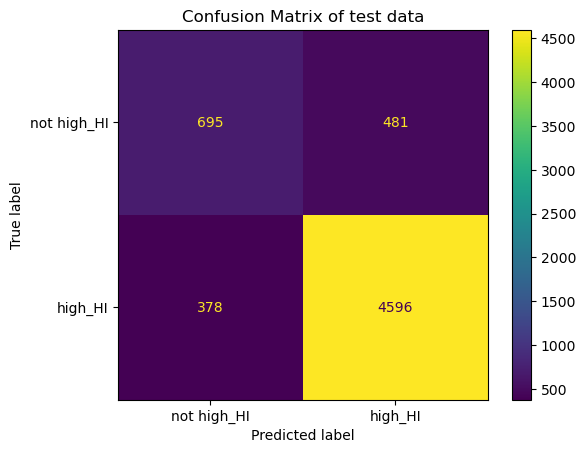

In [23]:
#scores for evaluation
evaluator(gs_M1)

As evident above, the main f1 score seems rather good at 91.45% with some overfit of almost 4%. This is due to overfitting with particularly with precision.
The secondary MCC score is around 53% and has quite significant over fit at around 23% which is quite severe and directs out attention to the false postives. 
Indeed, there is a relatively higher occurences of a false positives (top right quadrant) where ppapers from low_HI journal is wrongly predicted to be from high_HI journals. This is also likely to be an impact of an unbalanced data set so we can consider exploring other models to try and minimise the false negatives while maintaning the F1 score as far as possible.

## Method 2: TF-IDF Vectorizer + Multinomial naive Bayes
- TF-IDF Vectorizer is used to determine if assigning heavier weightage to less common words and lower weightage to more commons words would help to improve the score.
    - Parameters are kept the same for comparison
- MultinomialNB is also kept the same for direct comparison. This is even though TF-IDF vectorising gives fractions while MultinomialNB is supposed to use positive integers. However, the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) does mention that "in practice, fractional counts such as tf-idf may also work."

### Modeling


In [26]:
#Set up a pipeline
pipe_M2 = Pipeline([('tvec', TfidfVectorizer()),
                    ('nb', MultinomialNB())
                   ])

In [27]:
#Set pipline parameters
pipe_M2_params = {'tvec__max_features': [30000],   #max features for considering after finetuning in the background
                  'tvec__min_df': [2, 3],
                  'tvec__max_df': [.85, .9, .95],
                  'tvec__stop_words': ['english'],
                  'tvec__ngram_range': [(3, 4)],   #min number ngrams for considering after finetuning in the background
                  'nb__alpha': np.linspace(1,10,5)
                 }

In [28]:
# Instantiate GridSearchCV.
gs_M2 = GridSearchCV(pipe_M2,                     # what object are we optimizing?
                     param_grid = pipe_M2_params, # what parameters values are we searching?
                     cv=3,                        # 3-fold cross-validation.
                     scoring = 'f1',              # balanced to check both precision and recall 
                     n_jobs = -2,
                     verbose = 10
                    )

In [29]:
# Fit GridSearch to training data.
gs_M2.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'nb__alpha': array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ]),
                         'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [30000], 'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(3, 4)],
                         'tvec__stop_words': ['english']},
             scoring='f1', verbose=10)

In [243]:
#top 5 paramters ranked by test score.
pd.DataFrame(gs_M2.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__alpha,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,15.275370,0.053046,1.613583,0.071422,1.0,0.85,30000,3,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.85, 'tvec...",0.913604,0.914841,0.919313,0.915919,0.002452,1
3,13.848892,0.145822,1.862295,0.016581,1.0,0.9,30000,3,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.9, 'tvec_...",0.913604,0.914841,0.919313,0.915919,0.002452,1
5,14.130461,0.068989,1.918645,0.038111,1.0,0.95,30000,3,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.95, 'tvec...",0.913604,0.914841,0.919313,0.915919,0.002452,1
0,15.198498,0.189327,1.591513,0.040434,1.0,0.85,30000,2,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.85, 'tvec...",0.909905,0.909239,0.913262,0.910802,0.001761,4
2,14.094589,0.570826,1.748569,0.101215,1.0,0.9,30000,2,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.9, 'tvec_...",0.909905,0.909239,0.913262,0.910802,0.001761,4


#### Pickle

In [34]:
##export pickle
#if not os.path.exists('pkl/'):
#    os.makedirs('pkl/')
#
#pickle.dump(gs_M2, open('pkl/gs_M2.pkl', 'wb'))
#pickle.dump(pipe_M2, open('pkl/pipe_M2.pkl', 'wb'))

In [35]:
##import pickle
#gs_M2 = pickle.load(open('pkl/gs_M2.pkl', 'rb'))
#pipe_M2 = pickle.load(open('pkl/pipe_M2.pkl', 'rb'))


### Scoring evaluation
Same as method 1
- Primary F1 score
- secondary MCC

In [36]:
#get best output from gs
gs_M2.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=30000, min_df=3,
                                 ngram_range=(3, 4), stop_words='english')),
                ('nb', MultinomialNB())])

Best estimator from gridsearch: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=30000, min_df=3,
                                 ngram_range=(3, 4), stop_words='english')),
                ('nb', MultinomialNB())])
_________________________________________
Score metrics of train data:
----------------------------------------
Accuracy score (Predictive Value): 0.9092
Specificity (True Negative Rate) score: 0.5444
Sensitivity (True Positive Rate) score: 0.9954
Precision (Positive Predictive Value) score: 0.9023
F1 score: 0.9466
MCC score (phi-coefficient): 0.6846

__________________________________________________
 Score metrics of test data:
----------------------------------------
Accuracy score (Predictive Value): 0.8662
Specificity (True Negative Rate) score: 0.3257
Sensitivity (True Positive Rate) score: 0.9940
Precision (Positive Predictive Value) score: 0.8618
F1 score: 0.9232
MCC score (phi-coefficient): 0.5022
________________________________

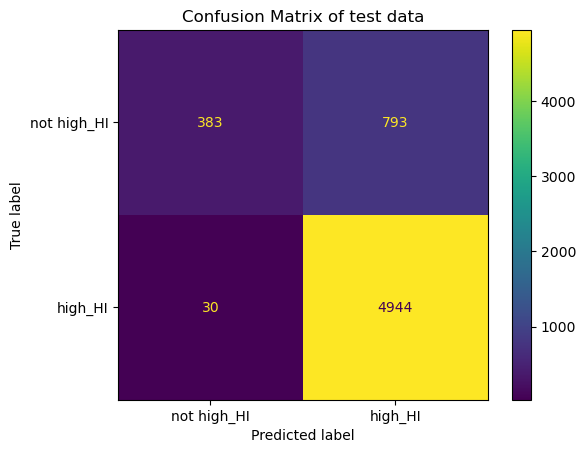

In [37]:
#scores for evaluation
evaluator(gs_M2)

It seems like using the TFID-Vectorizer improved the f1 scores a little from around 91.45% % to almost 92.32% when compared to Count Vectorizer and a lower overfit of around 2.3%. However, it caused the the MCC score to decrease from 53.36 % to 50.22% but reducing the over fit from around 23% to 18%.

There is now lower false negatives as can be see with the bottom left quadrant but false positive (top right has increased 1.5 times. This is likely due to TF-IDF Vectorizer assigning heavier weightage to less common words and lower weightage to more commons words or in this case higher ngrams words which are beginning to be more specific to their respective journals. 

Neverthelss, from understanding the confusion maatrix, the data imbalance is causing the false positives to be quite significant in the entire negative category(low_HI journal). Thus, it would be good to explore other ways such as oversampling and complement Naive Bayes to improve the score and fit.

### Modeling


In [26]:
#Set up a pipeline
pipe_M2 = Pipeline([('tvec', TfidfVectorizer()),
                    ('nb', MultinomialNB())
                   ])

In [27]:
#Set pipline parameters
pipe_M2_params = {'tvec__max_features': [30000],   #max features for considering after finetuning in the background
                  'tvec__min_df': [2, 3],
                  'tvec__max_df': [.85, .9, .95],
                  'tvec__stop_words': ['english'],
                  'tvec__ngram_range': [(3, 4)],   #min number ngrams for considering after finetuning in the background
                  'nb__alpha': np.linspace(1,10,5)
                 }

In [28]:
# Instantiate GridSearchCV.
gs_M2 = GridSearchCV(pipe_M2,                     # what object are we optimizing?
                     param_grid = pipe_M2_params, # what parameters values are we searching?
                     cv=3,                        # 3-fold cross-validation.
                     scoring = 'f1',              # balanced to check both precision and recall 
                     n_jobs = -2,
                     verbose = 10
                    )

In [29]:
# Fit GridSearch to training data.
gs_M2.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'nb__alpha': array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ]),
                         'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [30000], 'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(3, 4)],
                         'tvec__stop_words': ['english']},
             scoring='f1', verbose=10)

In [30]:
pd.DataFrame(gs_M2.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__alpha,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,15.275370,0.053046,1.613583,0.071422,1.0,0.85,30000,3,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.85, 'tvec...",0.913604,0.914841,0.919313,0.915919,0.002452,1
3,13.848892,0.145822,1.862295,0.016581,1.0,0.9,30000,3,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.9, 'tvec_...",0.913604,0.914841,0.919313,0.915919,0.002452,1
5,14.130461,0.068989,1.918645,0.038111,1.0,0.95,30000,3,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.95, 'tvec...",0.913604,0.914841,0.919313,0.915919,0.002452,1
0,15.198498,0.189327,1.591513,0.040434,1.0,0.85,30000,2,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.85, 'tvec...",0.909905,0.909239,0.913262,0.910802,0.001761,4
2,14.094589,0.570826,1.748569,0.101215,1.0,0.9,30000,2,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.9, 'tvec_...",0.909905,0.909239,0.913262,0.910802,0.001761,4


In [31]:
#get coefficents
ngram_counts_M2 = ngram_tvec_coefs(gs_M2, X_train, y_train)
ngram_counts_M2.sort_values(by = 0, ascending = False)[:40]

high_HI,0,1
relative standard deviation,23.630517,64.676007
chromatography mass spectrometry,18.650823,63.713159
ion selective electrode,14.901440,7.284102
gas chromatography mass,14.881539,42.453656
procedure developed determination,13.883409,1.509595
high performance liquid,13.610774,74.053576
performance liquid chromatography,13.300907,78.681956
gas chromatography mass spectrometry,13.169126,41.301460
inductively coupled plasma,13.090364,58.225657
high performance liquid chromatography,12.748048,71.192843


In [32]:
ngram_counts_M2.sort_values(by = 1, ascending = False)[:40]

high_HI,0,1
tandem mass spectrometry,5.851098,84.292699
performance liquid chromatography,13.300907,78.681956
high performance liquid,13.610774,74.053576
solid phase extraction,9.058546,72.016225
high performance liquid chromatography,12.748048,71.192843
relative standard deviation,23.630517,64.676007
chromatography mass spectrometry,18.650823,63.713159
inductively coupled plasma,13.090364,58.225657
chromatography tandem mass,3.603937,51.335686
chromatography tandem mass spectrometry,3.326560,50.191599


In [34]:
##export pickle
#if not os.path.exists('pkl/'):
#    os.makedirs('pkl/')
#
#pickle.dump(gs_M2, open('pkl/gs_M2.pkl', 'wb'))
#pickle.dump(pipe_M2, open('pkl/pipe_M2.pkl', 'wb'))

In [35]:
##import pickle
#gs_M2 = pickle.load(open('pkl/gs_M2.pkl', 'rb'))
#pipe_M2 = pickle.load(open('pkl/pipe_M2.pkl', 'rb'))


### Scoring evaluation
similar to Method 1

In [36]:
#get best output from gs
gs_M2.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=30000, min_df=3,
                                 ngram_range=(3, 4), stop_words='english')),
                ('nb', MultinomialNB())])

Best estimator from gridsearch: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=30000, min_df=3,
                                 ngram_range=(3, 4), stop_words='english')),
                ('nb', MultinomialNB())])
_________________________________________
Score metrics of train data:
----------------------------------------
Accuracy score (Predictive Value): 0.9092
Specificity (True Negative Rate) score: 0.5444
Sensitivity (True Positive Rate) score: 0.9954
Precision (Positive Predictive Value) score: 0.9023
F1 score: 0.9466
MCC score (phi-coefficient): 0.6846

__________________________________________________
 Score metrics of test data:
----------------------------------------
Accuracy score (Predictive Value): 0.8662
Specificity (True Negative Rate) score: 0.3257
Sensitivity (True Positive Rate) score: 0.9940
Precision (Positive Predictive Value) score: 0.8618
F1 score: 0.9232
MCC score (phi-coefficient): 0.5022
________________________________

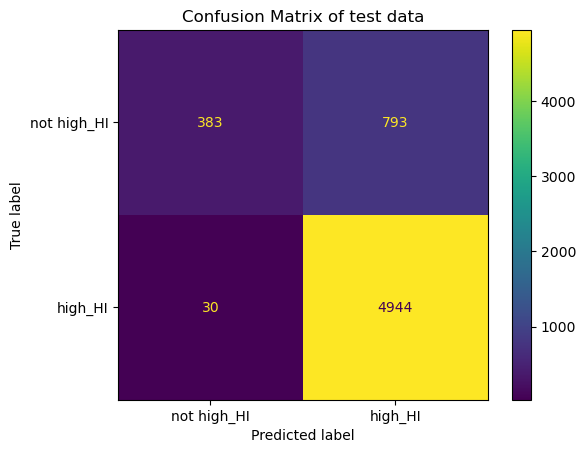

In [37]:
#scores for evaluation
evaluator(gs_M2)

It seems like using the TFID-Vectorizer improved the f1 scores alittle from around 93% to almost 95% when compared to Count Vectorizer. However, it casued the the MCC score to decrease from 67% to 72% with around 2% overfit. This translates to lower false positives as can be see with the top right quadrant. This is likely due to TF-IDF Vectorizer assigning heavier weightage to less common words and lower weightage to more commons words or in this case higher ngrams words which are beginning to be more specific to their respective journals. 

Neverthelss, form understanding the confusion maatrix, the data imbalance is causing the false positives to be quite significant in the entire negative category(low_HI journal). Thus, it would be good to explore other ways such as oversampling and complement Naive Bayes to improve the score and fit.

## Method 3: Reducing overfit.
- As the dataset is unbalanced and it is potentially an issue, there are a few ways to deal with the issue. Since the train and test data has already been stratified when splitting, this leave a few options.
    1. Undersample the majority class but it reduces the overall dataset
    2. Oversample the minority class is preferred<br>
    3. Try ComplementNB is particularly suited for imbalanced data sets
- Various parameters are kept the same for direct comparison.

### Method 3A: TfidfVectorizer + Complement Naive Bayes


#### Modeling


In [200]:
#Set up a pipeline
pipe_M3A = Pipeline([('tvec', TfidfVectorizer()),
                     ('cnb', ComplementNB())
                    ])

In [72]:
#Set pipline parameters
pipe_M3A_params = {'tvec__max_features': [30000], #max features for considering after finetuning in the background
                  'tvec__min_df': [2, 4],
                  'tvec__max_df': [.85, .9, .95],
                  'tvec__stop_words': ['english'],
                  'tvec__ngram_range': [(3, 4)],  #min number ngrams for considering after finetuning in the background
                  'cnb__alpha': np.linspace(1,10,5)
                 }

In [73]:
# Instantiate GridSearchCV.
gs_M3A = GridSearchCV(pipe_M3A,                   
                     param_grid = pipe_M3A_params,
                     cv=3,                        # 3-fold cross-validation.
                     scoring = 'f1',              # balanced to check both precision and recall 
                     n_jobs = -2,
                     verbose = 10
                    )


In [74]:
# Fit GridSearch to training data.
gs_M3A.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('cnb', ComplementNB())]),
             n_jobs=-2,
             param_grid={'cnb__alpha': array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ]),
                         'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [30000], 'tvec__min_df': [2, 4],
                         'tvec__ngram_range': [(3, 4)],
                         'tvec__stop_words': ['english']},
             scoring='f1', verbose=10)

In [245]:
#top 5 paramters ranked by test score.
pd.DataFrame(gs_M3A.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cnb__alpha,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,14.119604,0.262566,1.768284,0.181911,5.5,0.9,30000,2,"(3, 4)",english,"{'cnb__alpha': 5.5, 'tvec__max_df': 0.9, 'tvec...",0.894065,0.895625,0.901873,0.897188,0.003374,1
16,14.047538,0.258242,1.828840,0.144810,5.5,0.95,30000,2,"(3, 4)",english,"{'cnb__alpha': 5.5, 'tvec__max_df': 0.95, 'tve...",0.894065,0.895625,0.901873,0.897188,0.003374,1
12,14.451897,0.013726,1.821683,0.065984,5.5,0.85,30000,2,"(3, 4)",english,"{'cnb__alpha': 5.5, 'tvec__max_df': 0.85, 'tve...",0.894065,0.895625,0.901873,0.897188,0.003374,1
6,15.916646,0.097677,1.986358,0.032446,3.25,0.85,30000,2,"(3, 4)",english,"{'cnb__alpha': 3.25, 'tvec__max_df': 0.85, 'tv...",0.893706,0.895952,0.901796,0.897152,0.003410,4
8,14.469062,0.149820,1.822747,0.041874,3.25,0.9,30000,2,"(3, 4)",english,"{'cnb__alpha': 3.25, 'tvec__max_df': 0.9, 'tve...",0.893706,0.895952,0.901796,0.897152,0.003410,4


#### Pickle

In [78]:
#if not os.path.exists('pkl/'):
#    os.makedirs('pkl/')
#
#pickle.dump(gs_M3A, open('pkl/gs_M3A.pkl', 'wb'))
#pickle.dump(pipe_M3A, open('pkl/pipe_M3A.pkl', 'wb'))

In [79]:
##import pickle
#gs_M3A = pickle.load(open('pkl/gs_M3A.pkl', 'rb'))
#pipe_M3A = pickle.load(open('pkl/pipe_M3A.pkl', 'rb'))

#### Scoring evaluation
Same as method 1
- Primary F1 score
- secondary MCC

In [80]:
#get best output from gs
gs_M3A.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=30000, min_df=2,
                                 ngram_range=(3, 4), stop_words='english')),
                ('cnb', ComplementNB(alpha=5.5))])

Best estimator from gridsearch: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=30000, min_df=2,
                                 ngram_range=(3, 4), stop_words='english')),
                ('cnb', ComplementNB(alpha=5.5))])
_________________________________________
Score metrics of train data:
----------------------------------------
Accuracy score (Predictive Value): 0.9061
Specificity (True Negative Rate) score: 0.7718
Sensitivity (True Positive Rate) score: 0.9379
Precision (Positive Predictive Value) score: 0.9456
F1 score: 0.9417
MCC score (phi-coefficient): 0.7007

__________________________________________________
 Score metrics of test data:
----------------------------------------
Accuracy score (Predictive Value): 0.8324
Specificity (True Negative Rate) score: 0.6250
Sensitivity (True Positive Rate) score: 0.8814
Precision (Positive Predictive Value) score: 0.9086
F1 score: 0.8948
MCC score (phi-coefficient): 0.4844
_______________________

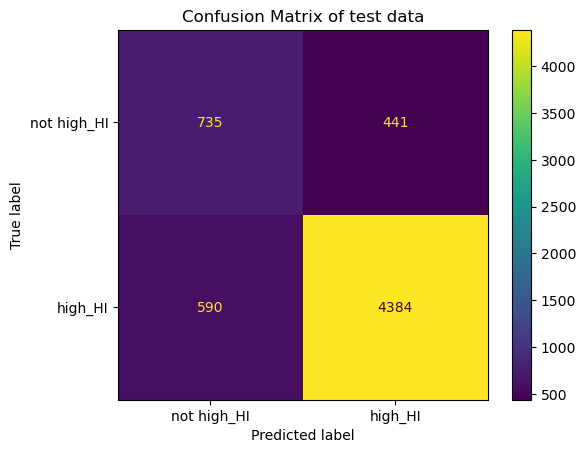

In [81]:
#scores for evaluation
evaluator(gs_M3A)

Using the CNB seems to not improve the metrics results, with f1 score dropping from around 92.3% in model 2 to around 89.5%, and overfitting has actually increase from around 2.3% to 4.7%. The metric scores in general has also dropped, with the mcc score dropping almost 2% to 48%. THe reason is clear with the false negative spiking up. 

It may be that this peculiarity of the situation where forcing out high ngrams words/features is causing the model to not be effectively categorised since the models seems to be performing worse and worse.

### Method 3B: Random Oversampling + TfidfVectorizer + Multinomial Naive Bayes
Random Oversampling using imblearn library

In [202]:
# Randomly over sample the minority class
#instantiate ROS
ros = RandomOverSampler(random_state=42)

#reshape to fit oversampler
X_train_reshaped = X_train.values.reshape(-1, 1)

#fit and resample
X_train_ros, y_train_ros = ros.fit_resample(X_train_reshaped, y_train)

#### Modeling


In [206]:
#Set up a pipeline
pipe_M3B = Pipeline([('tvec', TfidfVectorizer(lowercase = False)),
                     ('nb', MultinomialNB())
                    ])

In [207]:
#Set pipline parameters
pipe_M3B_params = {'tvec__max_features': [30000], #max features for considering after finetuning in the background
                   'tvec__min_df': [2, 4],
                   'tvec__max_df': [.85, .9, .95],
                   'tvec__stop_words': ['english'],
                   'tvec__ngram_range': [(3, 4)],  #min number ngrams for considering after finetuning in the background
                   'nb__alpha': np.linspace(1,10,5)
                  }

In [208]:
# Instantiate GridSearchCV.
gs_M3B = GridSearchCV(pipe_M3B,                     # what object are we optimizing?
                     param_grid = pipe_M3B_params, # what parameters values are we searching?
                     cv=3,                        # 3-fold cross-validation.
                     scoring = 'f1',              # balanced to check both precision and recall 
                     n_jobs = -2,
                     verbose = 10
                    )


In [209]:
# Fit GridSearch to training data.
gs_M3B.fit(X_train_ros.ravel(), y_train_ros.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('nb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'nb__alpha': array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ]),
                         'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [30000], 'tvec__min_df': [2, 4],
                         'tvec__ngram_range': [(3, 4)],
                         'tvec__stop_words': ['english']},
             scoring='f1', verbose=10)

In [246]:
#top 5 paramters ranked by test score.
pd.DataFrame(gs_M3B.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__alpha,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,22.226506,0.319421,2.934424,0.064495,1.0,0.85,30000,2,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.85, 'tvec...",0.835432,0.847829,0.845614,0.842958,0.005398,1
2,18.984030,2.235124,2.922294,0.067984,1.0,0.9,30000,2,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.9, 'tvec_...",0.835432,0.847829,0.845614,0.842958,0.005398,1
4,18.412985,1.050730,2.897565,0.046447,1.0,0.95,30000,2,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.95, 'tvec...",0.835432,0.847829,0.845614,0.842958,0.005398,1
1,21.945104,0.220836,2.944946,0.011026,1.0,0.85,30000,4,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.85, 'tvec...",0.831724,0.843039,0.848183,0.840982,0.006875,4
3,17.802764,0.079947,2.888735,0.028640,1.0,0.9,30000,4,"(3, 4)",english,"{'nb__alpha': 1.0, 'tvec__max_df': 0.9, 'tvec_...",0.831724,0.843039,0.848183,0.840982,0.006875,4


In [121]:
if not os.path.exists('pkl/'):
    os.makedirs('pkl/')

pickle.dump(gs_M3B, open('pkl/gs_M3B.pkl', 'wb'))
pickle.dump(pipe_M3B, open('pkl/pipe_M3B.pkl', 'wb'))

In [92]:
##import pickle
#gs_M3B = pickle.load(open('pkl/gs_M3B.pkl', 'rb'))
#pipe_M3B = pickle.load(open('pkl/pipe_M3B.pkl', 'rb'))

#### Scoring evaluation
Same as method 1
- Primary F1 score
- secondary MCC

In [211]:
#get best output from gs
gs_M3B.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(lowercase=False, max_df=0.85,
                                 max_features=30000, min_df=2,
                                 ngram_range=(3, 4), stop_words='english')),
                ('nb', MultinomialNB())])

Best estimator from gridsearch: Pipeline(steps=[('tvec',
                 TfidfVectorizer(lowercase=False, max_df=0.85,
                                 max_features=30000, min_df=2,
                                 ngram_range=(3, 4), stop_words='english')),
                ('nb', MultinomialNB())])
_________________________________________
Score metrics of train data:
----------------------------------------
Accuracy score (Predictive Value): 0.8857
Specificity (True Negative Rate) score: 0.8522
Sensitivity (True Positive Rate) score: 0.8936
Precision (Positive Predictive Value) score: 0.9624
F1 score: 0.9267
MCC score (phi-coefficient): 0.6783

__________________________________________________
 Score metrics of test data:
----------------------------------------
Accuracy score (Predictive Value): 0.8176
Specificity (True Negative Rate) score: 0.6531
Sensitivity (True Positive Rate) score: 0.8565
Precision (Positive Predictive Value) score: 0.9126
F1 score: 0.8836
MCC score (phi-coe

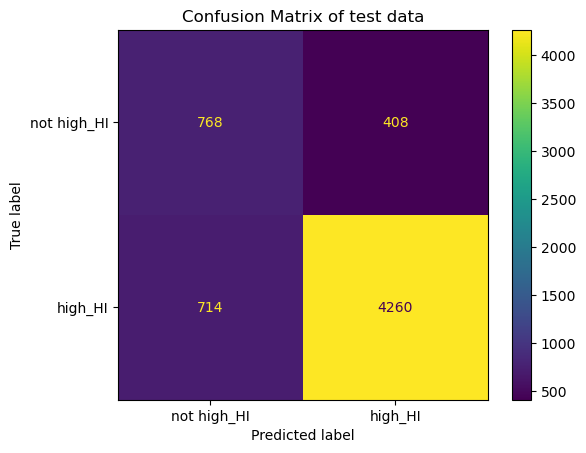

In [227]:
#scores for evaluation
evaluator(gs_M3B)

As compared to M2, the added Oversampling portions seems cause a marginal decline in the score from from around basline 92.7% to around 88.3% and the overfit sems to be worse as well. This is suprising and would require some investigation. 

It is possible that the oversampling may be causing this issue of false negatives. Another oversampler method or undersampling may alleviate this issue. One way would be to pair over sampling with logsitic regreions to reduce overfit via regularisation. 

But for this purpose, it would be good to skip this model. 

## Method 4: Oversampler + Count Vectorizer + Logistic Regression
- Keeping Count Vectorizer the same
    - Parameters are kept the same for comparison
- While oversampling did not help, switching to Logistic Regression may require a more balance dataset
- Logistic Regression is used to utilise regularisation function to try and reduce the overfit that seems to plauge the MultiNB model.

### Modeling


In [137]:
#Set up a pipeline
pipe_M4 = Pipeline([('cvec', CountVectorizer(lowercase = False)),
                    ('logreg', LogisticRegression())
                   ])

In [138]:
#Set pipline parameters
pipe_M4_params = {'cvec__max_features': [30000],
                  'cvec__min_df': [2, 4],
                  'cvec__max_df': [.85, .9, .95],
                  'cvec__stop_words': ['english'],
                  'cvec__ngram_range': [(3,4)],
                  'logreg__penalty': ['l1','l2'],
                  'logreg__C': [0.1,0.5,1],
                  'logreg__solver': ['liblinear'],
                  'logreg__max_iter': [1000,2000]
                 }

In [139]:
# Instantiate GridSearchCV.
gs_M4 = GridSearchCV(pipe_M4,                     # what object are we optimizing?
                     param_grid = pipe_M4_params, # what parameters values are we searching?
                     cv=3,                        # 3-fold cross-validation.
                     scoring = 'f1',              # balanced to check both precision and recall 
                     n_jobs = -2,
                     verbose = 10
                    )

In [141]:
# Fit GridSearch to training data.
gs_M4.fit(X_train_ros.ravel(), y_train_ros.ravel())

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-2,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [30000], 'cvec__min_df': [2, 4],
                         'cvec__ngram_range': [(3, 4)],
                         'cvec__stop_words': ['english'],
                         'logreg__C': [0.1, 0.5, 1],
                         'logreg__max_iter': [1000, 2000],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear']},
             scoring='f1', verbose=10)

In [247]:
#top 5 paramters ranked by test score.
pd.DataFrame(gs_M4.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,param_logreg__C,param_logreg__max_iter,param_logreg__penalty,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
35,17.478811,0.083068,2.500272,0.116875,0.9,30000,2,"(3, 4)",english,1,2000,l2,liblinear,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.915113,0.938962,0.935205,0.92976,0.01047,1
59,17.545321,0.301390,2.651653,0.031681,0.95,30000,2,"(3, 4)",english,1,2000,l2,liblinear,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.915113,0.938962,0.935205,0.92976,0.01047,1
57,17.915551,0.068931,2.635569,0.047780,0.95,30000,2,"(3, 4)",english,1,1000,l2,liblinear,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.915113,0.938962,0.935205,0.92976,0.01047,1
33,18.658561,0.184339,2.685950,0.039155,0.9,30000,2,"(3, 4)",english,1,1000,l2,liblinear,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.915113,0.938962,0.935205,0.92976,0.01047,1
9,17.430099,0.764131,2.452241,0.171672,0.85,30000,2,"(3, 4)",english,1,1000,l2,liblinear,"{'cvec__max_df': 0.85, 'cvec__max_features': 3...",0.915113,0.938962,0.935205,0.92976,0.01047,1


In [145]:
if not os.path.exists('pkl/'):
    os.makedirs('pkl/')

pickle.dump(gs_M4, open('pkl/gs_M4.pkl', 'wb'))
pickle.dump(pipe_M4, open('pkl/pipe_M4.pkl', 'wb'))

In [ ]:
#import pickle
#gs_M4 = pickle.load(open('pkl/gs_M4.pkl', 'rb'))
#pipe_M4 = pickle.load(open('pkl/pipe_M4.pkl', 'rb'))

### Scoring evaluation
Same as method 1
- Primary F1 score
- secondary MCC

In [147]:
#get best output from gs
gs_M4.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(lowercase=False, max_df=0.85,
                                 max_features=30000, min_df=2,
                                 ngram_range=(3, 4), stop_words='english')),
                ('logreg',
                 LogisticRegression(C=1, max_iter=1000, solver='liblinear'))])

Best estimator from gridsearch: Pipeline(steps=[('cvec',
                 CountVectorizer(lowercase=False, max_df=0.85,
                                 max_features=30000, min_df=2,
                                 ngram_range=(3, 4), stop_words='english')),
                ('logreg',
                 LogisticRegression(C=1, max_iter=1000, solver='liblinear'))])
_________________________________________
Score metrics of train data:
----------------------------------------
Accuracy score (Predictive Value): 0.9832
Specificity (True Negative Rate) score: 0.9393
Sensitivity (True Positive Rate) score: 0.9936
Precision (Positive Predictive Value) score: 0.9858
F1 score: 0.9896
MCC score (phi-coefficient): 0.9451

__________________________________________________
 Score metrics of test data:
----------------------------------------
Accuracy score (Predictive Value): 0.8728
Specificity (True Negative Rate) score: 0.4923
Sensitivity (True Positive Rate) score: 0.9628
Precision (Positive Pre

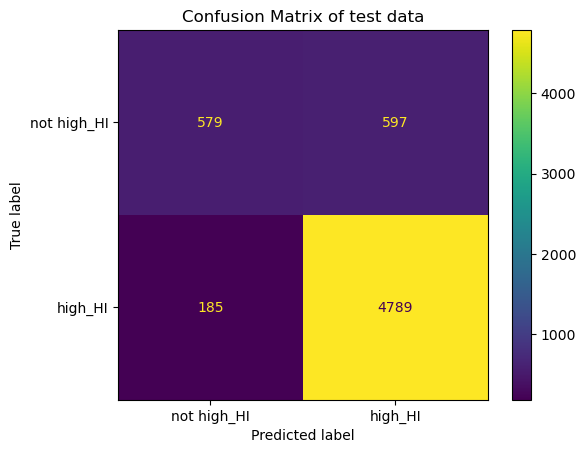

In [148]:
#scores for evaluation
evaluator(gs_M4)

With the oversampling and using logistic regression, the train f1 scores has imrpoved tp 99 % but the test f1 scores remains the same at 92%. MCC score has an even larger difference owing to the large overfit in specificity in this case. This a an unexpected result.

It seems like trying to solve the data imbalance via bootsstrapping (Oversampler) and trying to take advantage of regularization in Logistic Regression does not seems to help the case as the ngrams are much higher and the words are getting specific in its context but also appearing in both high and low journals. Perhaps having too high ngrams may be causing such a large drift between the results. Perhaps this model may not be suitable for this use case.

## Method 5: Oversampler + CVEC Vectorizer + Random Forest
Since the methods so far can be said to be parametric, perhaps a non-parametric classifier may be able to give a better result since with higher ngrams as it is unclear if the samples follows what kind of distribution anymore since the EDA was done on tokenised forms. 

- Keeping Count Vectorizer the same
    - Parameters are kept the same for comparison
- While oversampling did not help, switching to Logistic Regression may require a more balance dataset
- Random Forrest is used to utilise regularisation function to try adn reduce the overfit that seems to plauge the MultiNB model.

### Modeling


In [150]:
#Set up a pipeline
pipe_M5 = Pipeline([('cvec', CountVectorizer(lowercase = False)),
                    ('rf', RandomForestClassifier(n_estimators=100, class_weight = 'balanced'))
                   ])

In [237]:
#Set pipline parameters
pipe_M5_params = {'cvec__max_features': [30000],
                  'cvec__min_df': [2, 4],
                  'cvec__max_df': [.85, .9, .95],
                  'cvec__stop_words': ['english'],
                  'cvec__ngram_range': [(3, 4)],
                  'rf__n_estimators': [100],
                  'rf__max_depth': [20, 30],
                  'rf__min_samples_split': [(3, 4)],
                  }

In [152]:
# Instantiate GridSearchCV.
gs_M5 = GridSearchCV(pipe_M5,                     # what object are we optimizing?
                     param_grid = pipe_M5_params, # what parameters values are we searching?
                     cv=3,                        # 5-fold cross-validation.
                     scoring = 'f1',              # balanced to check both precision and recall 
                     n_jobs = -2,
                     verbose = 10
                    )

In [153]:
# Fit GridSearch to training data.
gs_M5.fit(X_train_ros.ravel(), y_train_ros.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-2,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [30000], 'cvec__min_df': [2, 4],
                         'cvec__ngram_range': [(3, 4)],
                         'cvec__stop_words': ['english'],
                         'rf__max_depth': [20, 30],
                         'rf__min_samples_split': [2],
                         'rf__n_estimators': [100]},
             scoring='f1', verbose=10)

In [248]:
#top 5 paramters ranked by test score.
pd.DataFrame(gs_M5.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,param_rf__max_depth,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,27.039890,0.281325,2.628470,0.138238,0.9,30000,4,"(3, 4)",english,30,2,100,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.648265,0.666792,0.668311,0.661123,0.009113,1
5,28.205773,0.310660,2.680950,0.104643,0.9,30000,2,"(3, 4)",english,30,2,100,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.644444,0.664913,0.662333,0.657230,0.009102,2
1,27.250333,0.556105,2.935699,0.027766,0.85,30000,2,"(3, 4)",english,30,2,100,"{'cvec__max_df': 0.85, 'cvec__max_features': 3...",0.642527,0.666919,0.661873,0.657106,0.010513,3
11,21.919192,4.522865,1.374706,0.113860,0.95,30000,4,"(3, 4)",english,30,2,100,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.645953,0.664038,0.659644,0.656545,0.007701,4
3,27.875663,0.863864,2.632787,0.033943,0.85,30000,4,"(3, 4)",english,30,2,100,"{'cvec__max_df': 0.85, 'cvec__max_features': 3...",0.629715,0.663772,0.664127,0.652538,0.016139,5


#### Pickle

In [154]:
#save pickle
#if not os.path.exists('pkl/'):
#    os.makedirs('pkl/')
#
#pickle.dump(gs_M5, open('pkl/gs_M5.pkl', 'wb'))
#pickle.dump(pipe_M5, open('pkl/pipe_M5.pkl', 'wb'))

In [ ]:
#open pickle
#import pickle
#gs_M5 = pickle.load(open('pkl/gs_M5.pkl', 'rb'))
#pipe_M5 = pickle.load(open('pkl/pipe_M5.pkl', 'rb'))

##alternate
#with open('pipe_M5.pkl', 'rb') as f:
#    pipeline = pickle.load(f)

### Scoring evaluation
Same as method 1
- Primary F1 score
- secondary MCC

In [155]:
#get best output from gs
gs_M5.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(lowercase=False, max_df=0.9,
                                 max_features=30000, min_df=4,
                                 ngram_range=(3, 4), stop_words='english')),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_depth=30))])

Best estimator from gridsearch: Pipeline(steps=[('cvec',
                 CountVectorizer(lowercase=False, max_df=0.9,
                                 max_features=30000, min_df=4,
                                 ngram_range=(3, 4), stop_words='english')),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        max_depth=30))])
_________________________________________
Score metrics of train data:
----------------------------------------
Accuracy score (Predictive Value): 0.6204
Specificity (True Negative Rate) score: 0.9577
Sensitivity (True Positive Rate) score: 0.5406
Precision (Positive Predictive Value) score: 0.9818
F1 score: 0.6973
MCC score (phi-coefficient): 0.3943

__________________________________________________
 Score metrics of test data:
----------------------------------------
Accuracy score (Predictive Value): 0.5789
Specificity (True Negative Rate) score: 0.8656
Sensitivity (True Positive Rate)

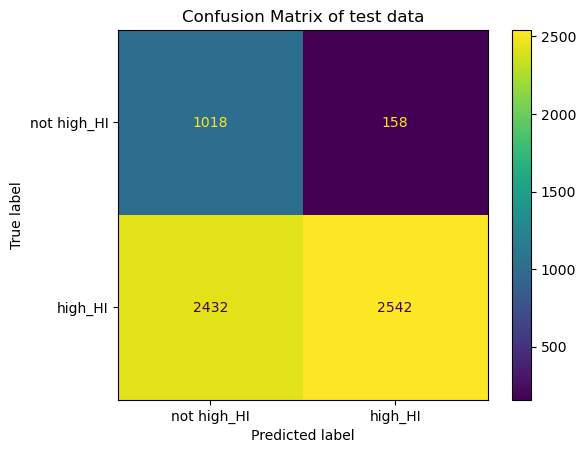

In [156]:
#scores for evaluation
evaluator(gs_M5)

This method seems to have led to an even worse f1 score of 66.3% so it seems like using the Random Forrest might not be a good classifier. This is unexpected but it may be the ngrams are much higher and the words are getting specific in its context but also appearing in both high and low journals. Perhaps having too high ngrams may be causing such a large drift between the results. For the current purpose, this model may not be suitable for this use case.

### Modeling


In [230]:
#Set up a pipeline
pipe_M5B = Pipeline([('cvec', CountVectorizer()),
                    ('rf', RandomForestClassifier())
                   ])

In [234]:
#Set pipline parameters
pipe_M5_params = {'cvec__max_features': [30000],
                  'cvec__min_df': [2, 4],
                  'cvec__max_df': [.85, .9, .95],
                  'cvec__stop_words': ['english'],
                  'cvec__ngram_range': [(3, 4)],
                  'rf__n_estimators': [100],
                  'rf__max_depth': [20, 30],
                  'rf__min_samples_split': [2,4],
                  }

In [235]:
# Instantiate GridSearchCV.
gs_M5B = GridSearchCV(pipe_M5B,                     # what object are we optimizing?
                     param_grid = pipe_M5B_params, # what parameters values are we searching?
                     cv=3,                        # 5-fold cross-validation.
                     scoring = 'f1',              # balanced to check both precision and recall 
                     n_jobs = -2,
                     verbose = 10
                    )

In [236]:
# Fit GridSearch to training data.
gs_M5B.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


ValueError: 
All the 36 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\benja\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\benja\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\benja\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\benja\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\benja\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\benja\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_split' parameter of RandomForestClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got (3, 4) instead.


In [ ]:
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/project_3/pkl/'):
    os.makedirs('/content/drive/MyDrive/Colab Notebooks/project_3/pkl/')

pickle.dump(gs_M5B, open('/content/drive/MyDrive/Colab Notebooks/project_3/pkl/gs_M5B.pkl', 'wb'))
pickle.dump(pipe_M5B, open('/content/drive/MyDrive/Colab Notebooks/project_3/pkl/pipe_M5B.pkl', 'wb'))


In [ ]:
#import pickle

#with open('pipe_M5B.pkl', 'wb') as f:
#    pickle.dump(pipeline, f)

### Scoring evaluation
 - Since it is important to assign both journals as best as possible even though there is data imbalanace, the Precision-Recall (PR) curve focuses on the minority class would not be used.
 - The Receiver Operating Characteristic (ROC) curve which covers both classes would be a better gauge.

In [ ]:
#get best output from gs
gs_M5B.best_estimator_

In [ ]:
#scores for evaluation
evaluator(gs_M5B)

From this result, it is obious that oversampling helps the situation since there the metrics took a hit of about 4-5% with specificty in particular, decreaased to about 65% for test and 80% for train which is terrible and highlight severe overfit and underfit at the same time. It like liek hyer parameter tuning would be better a better course of action.

In [187]:
from sklearn.metrics import classification_report, precision_recall_curve, auc

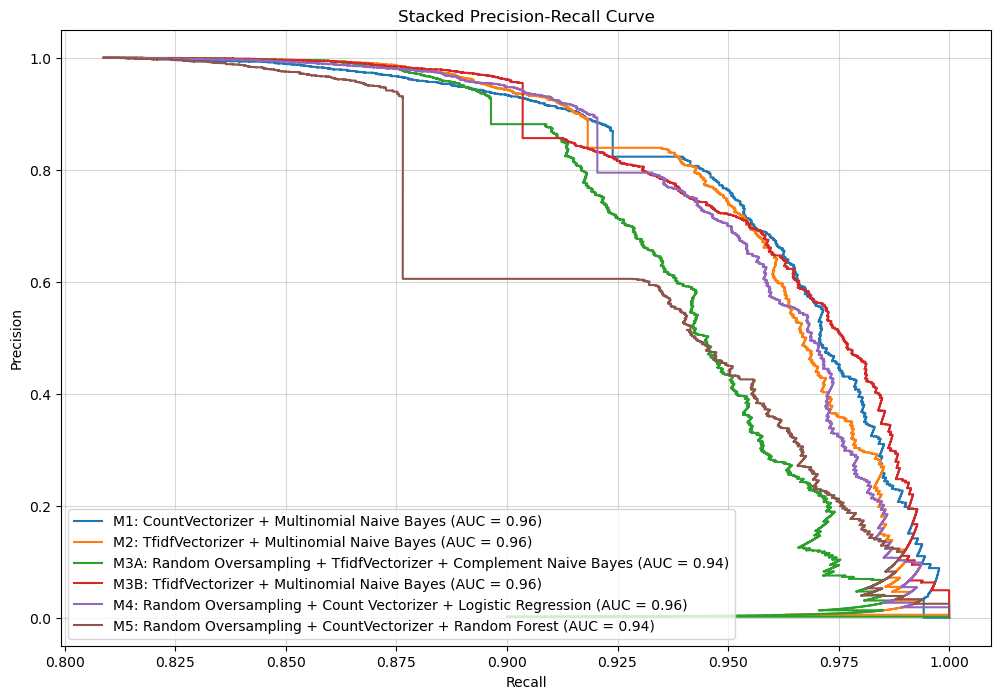

In [199]:
#get precision and recall
probs_M1 = gs_M1.best_estimator_.predict_proba(X_test)[:, 1]
probs_M2 = gs_M2.best_estimator_.predict_proba(X_test)[:, 1]
probs_M3A = gs_M3A.best_estimator_.predict_proba(X_test)[:, 1]
probs_M3B = gs_M3B.best_estimator_.predict_proba(X_test)[:, 1]
probs_M4 = gs_M4.best_estimator_.predict_proba(X_test)[:, 1]
probs_M5 = gs_M5.best_estimator_.predict_proba(X_test)[:, 1]


# Calculate pres and rec for each model
prec_M1, rec_M1, threshold_M1 = precision_recall_curve(y_test, probs_M1)
prec_M2, rec_M2, threshold_M2 = precision_recall_curve(y_test, probs_M2)
prec_M3A, rec_M3A, threshold_M3A = precision_recall_curve(y_test, probs_M3A)
prec_M3B, rec_M3B, threshold_M3B = precision_recall_curve(y_test, probs_M3B)
prec_M4, rec_M4, threshold_M4 = precision_recall_curve(y_test, probs_M4)       
prec_M5, rec_M5, threshold_M5 = precision_recall_curve(y_test, probs_M5)

# Calculate auc from pres and rec for each model
auc_M1 = auc(rec_M1, prec_M1)
auc_M2 = auc(rec_M2, prec_M2)
auc_M3A = auc(rec_M3A, prec_M3A)
auc_M3B = auc(rec_M3B, prec_M3B)
auc_M4 = auc(rec_M4, prec_M4)
auc_M5 = auc(rec_M5, prec_M5)                 

# Step 6: Plot the ROC curves
plt.figure(figsize=(12, 8))
plt.step(prec_M1, rec_M1, label="M1: CountVectorizer + Multinomial Naive Bayes (AUC = {:.2f})".format(auc_M1))
plt.step(prec_M2, rec_M2, label="M2: TfidfVectorizer + Multinomial Naive Bayes (AUC = {:.2f})".format(auc_M2))
plt.step(prec_M3A, rec_M3A, label="M3A: TfidfVectorizer + Complement Naive Bayes (AUC = {:.2f})".format(auc_M3A))
plt.step(prec_M3B, rec_M3B, label="M3B: Random Oversampling + TfidfVectorizer + Multinomial Naive Bayes (AUC = {:.2f})".format(auc_M3B))
plt.step(prec_M4, rec_M4, label="M4: Random Oversampling + Count Vectorizer + Logistic Regression (AUC = {:.2f})".format(auc_M4))
plt.step(prec_M5, rec_M5, label="M5: Random Oversampling + CountVectorizer + Random Forest (AUC = {:.2f})".format(auc_M5))

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
plt.title('Stacked Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True, alpha = 0.3)
plt.show()


## Models Score summary

| Model | Description                                                     | F1 train | F1 test | MCC train | MCC test |
|-------|-----------------------------------------------------------------|----------|---------|-----------|----------|
| 1     | Count Vectorizer + Multinomial naive Bayes                      | 0.9533   | 0.9145  | 0.7649    | 0.5336   |
| 2     | TF-IDF Vectorizer + Multinomial naive Bayes                     | 0.9466   | 0.9232  | 0.6846    | 0.5022   |
| 3A    | TfidfVectorizer + Complement Naive Bayes                        | 0.9417   | 0.8948  | 0.7007    | 0.4844   |
| 3B    | Random Oversampling + TfidfVectorizer + Multinomial Naive Bayes | 0.9267   | 0.8836  | 0.6783    | 0.4685   |
| 4     | Oversampler + Count Vectorizer + Logistic Regression            | 0.9896   | 0.9245  | 0.9451    | 0.5427   |
| 5     | Oversampler + CVEC Vectorizer + Random Forest                   | 0.6973   | 0.6625  | 0.3943    | 0.2985   |

From the summary of scores above, it would seem F1 scores, for test and train are relatively high except for model 5 which is the random forrest. Since the F1 score is sthe main metric, model 1,2 and 3A are fairly acceptable with similar overfit. 

MCC scores however are generally low but it is useful to have a secondary metric to reference. In this case, based on the overfit of the MCC scores Models 1 and 2 are acceptable with similar overfit percentage. Since Model 2 has lower overfit, (~2%) and higher test f1 scores, it is selected. 

With a score of 0.9232, it shows that it can classify the two journals quite well.

# Getting ngrams by count

Using model 2 we can get the ngrams out to show the top ranking words tha can be used to advise the researchers.

In [249]:
#get coefficents
ngram_counts_M2 = ngram_tvec_coefs(gs_M2, X_train, y_train)
ngram_counts_M2.sort_values(by = 0, ascending = False)[:40]

high_HI,0,1
relative standard deviation,23.630517,64.676007
chromatography mass spectrometry,18.650823,63.713159
ion selective electrode,14.901440,7.284102
gas chromatography mass,14.881539,42.453656
procedure developed determination,13.883409,1.509595
high performance liquid,13.610774,74.053576
performance liquid chromatography,13.300907,78.681956
gas chromatography mass spectrometry,13.169126,41.301460
inductively coupled plasma,13.090364,58.225657
high performance liquid chromatography,12.748048,71.192843


In [284]:
top_ngram = ngram_counts_M2.sort_values(by = 1, ascending = False)[:25]

In [302]:
low_HI_words = ngram_counts_M2.sort_values(by = 0, ascending = False)[:25][0]
high_HI_words = ngram_counts_M2.sort_values(by = 1, ascending = False)[:25][1]


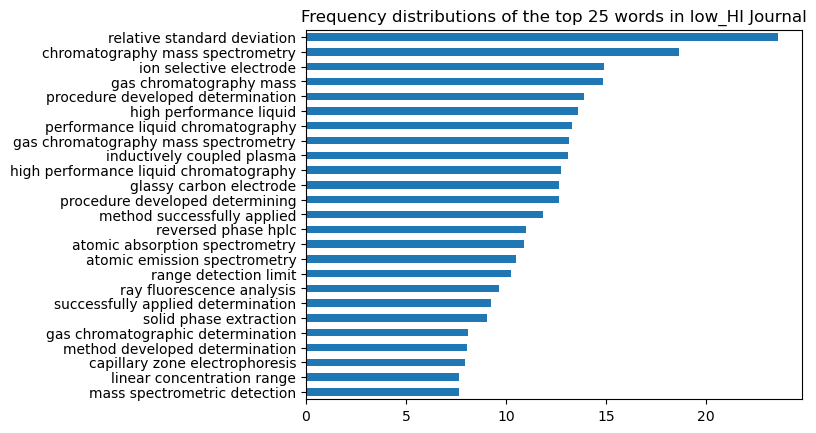

In [310]:
low_HI_words.sort_values(ascending = True).plot(kind = 'barh', title = 'Frequency distributions of the top 25 words in low_HI Journal');

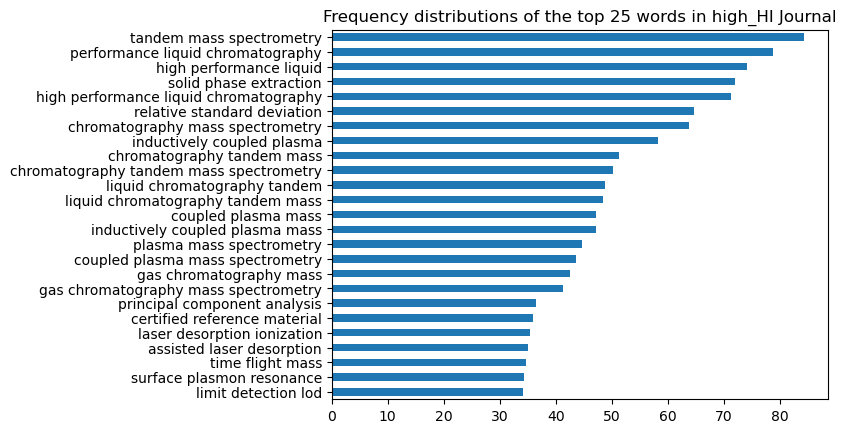

In [311]:
high_HI_words.sort_values(ascending = True).plot(kind = 'barh', title = 'Frequency distributions of the top 25 words in high_HI Journal');

From the two plots above, we can see that the top words does overlap alittle such as performance liquid chromatogaphy but this shows that the key words are not mutually exclusive. In fact, any overlap just shows the value of published papers in relation to the key words. 
Thus, the words can be very useful in advising the research 

# Current limitations and future directions

For future development, assess to larger databsses would prove beneficial since we can have a larger dataset which woud improve robustness for this and the journals can be further fine tuned to be of even mroe similar topic to see if it can still be seperated well. Addtionally, other classifiers and methods should be explored to resolve the data imbalance as well as further hyper parameter tune to improve the MCC scores and common ngrams.

# Conclusion

Through the trials of 6 models, and assessment via the primary metric f1 scores as well as the secondary metric MCC, Model 2 is selected since it has lower overfit (~2%) and higher test f1 score. With a f1 score of 0.9232, it can be established that the two journals of differing HI_index can be classified with emphasis on the true positives via the harmonic balance of recall and precision, which is the targeted high_HI journal. With the model's ability to classify between a high and low HI journal, this established that the keywords in the abstract are different. This permits the extraction of the top key words that are prevalent in the target (high_HI journal) which can then be shared with the researcher who either want to know which area to research into or even prepare their paper accordingly for submisssion. 